In [1]:
import argparse
import datetime
import logging
import os
import sys
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data

In [3]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

In [4]:
import utils

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# physical constraints and sampling
samples = {"pde": 5000, "bc":500, "fc":500}

bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)

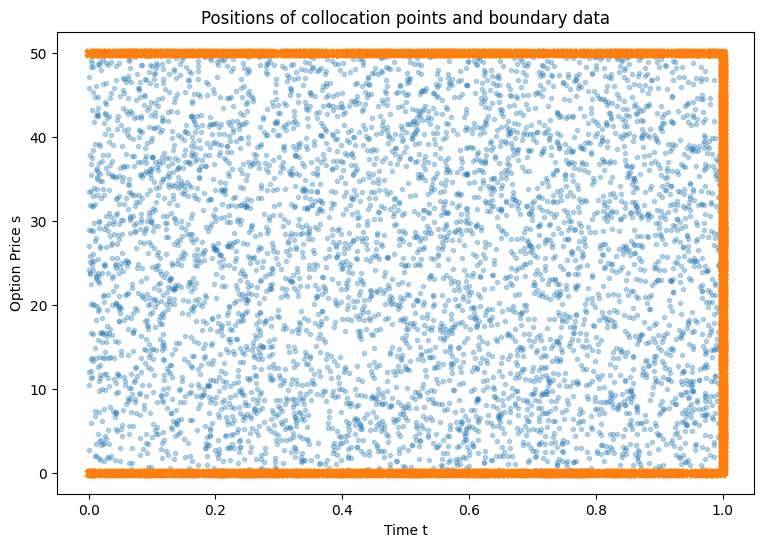

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter([sublist[0] for sublist in n_st_train], [sublist[1] for sublist in n_st_train], marker='.',alpha=0.3)
plt.scatter([sublist[0] for sublist in bc_st_train], [sublist[1] for sublist in bc_st_train], marker='X')
plt.xlabel('Time t')
plt.ylabel('Option Price s')

plt.title('Positions of collocation points and boundary data');

# Network

In [6]:
class AdaptiveLinear(nn.Linear):
    r"""Applies a linear transformation to the input data as follows
    :math:`y = naxA^T + b`.
    More details available in Jagtap, A. D. et al. Locally adaptive
    activation functions with slope recovery for deep and
    physics-informed neural networks, Proc. R. Soc. 2020.

    Parameters
    ----------
    in_features : int
        The size of each input sample
    out_features : int 
        The size of each output sample
    bias : bool, optional
        If set to ``False``, the layer will not learn an additive bias
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice 
        (self.A is the learnable parameter which is initialized by the 
        self.adaptive rate. To create a learnable parameter for each neuron, 
        it multiplies the self.adaptive rate to the number of input features.)
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, in_features, out_features, bias=True, adaptive_rate=None, adaptive_rate_scaler=None):
        super(AdaptiveLinear, self).__init__(in_features, out_features, bias)
        self.adaptive_rate = adaptive_rate
        self.adaptive_rate_scaler = adaptive_rate_scaler
        if self.adaptive_rate:
            self.A = nn.Parameter(self.adaptive_rate * torch.ones(self.in_features))
            if not self.adaptive_rate_scaler:
                self.adaptive_rate_scaler = 10.0
            
    def forward(self, input):
        if self.adaptive_rate:
            return nn.functional.linear(self.adaptive_rate_scaler * self.A * input, self.weight, self.bias)
        return nn.functional.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return (
            f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}, '
            f'adaptive_rate={self.adaptive_rate is not None}, adaptive_rate_scaler={self.adaptive_rate_scaler is not None}'
        )



class Net(nn.Module):
    r"""Neural approximator for the unknown function that is supposed
    to be solved.

    More details available in Raissi, M. et al. Physics-informed neural
    networks: A deep learning framework for solving forward and inverse
    problems involving nonlinear partial differential equations, J.
    Comput. Phys. 2019.

    Parameters
    ----------
    sizes : list
        Each element represents the number of neuron per layer
    activation : callable 
        Activation function
    dropout_rate : float, optional
        Dropout rate for regulrization during training process and
        uncertainty quantification by means of Monte Carlo dropout
        procedure while performing evaluation
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, sizes, activation, dropout_rate=0.0, adaptive_rate=None, adaptive_rate_scaler=None):
        super(Net, self).__init__()
        self.regressor = nn.Sequential(
            *[Net.linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler)
            for in_features, out_features in zip(sizes[:-1], sizes[1:-1])],     
            AdaptiveLinear(sizes[-2], sizes[-1]) # output layer is regular linear transformation
            )
        
    def forward(self, x):
        return self.regressor(x)

    @staticmethod
    def linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler):
        activation_dispatcher = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU()],
            ['relu', nn.ReLU()],
            ['tanh', nn.Tanh()],
            ['sigmoid', nn.Sigmoid()],
            # ['swish', Swish()]
        ])
        return nn.Sequential(
            AdaptiveLinear(in_features, out_features, adaptive_rate=adaptive_rate, adaptive_rate_scaler=adaptive_rate_scaler),
            activation_dispatcher[activation],
            nn.Dropout(dropout_rate),
            )

In [7]:
IPINN = Net(
    sizes=[2, 50, 50, 50, 50, 50, 50, 50, 50, 1], activation='relu', dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0
    )
IPINN.cuda()

Net(
  (regressor): Sequential(
    (0): Sequential(
      (0): AdaptiveLinear(in_features=2, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (1): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (2): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (3): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (4): Sequential(
      (0): AdaptiveLinear(in_features=50, out_features=50, bias=True, adaptive_rate=True, adaptive_rate_scaler=True)
      (1): ReLU()
      (2)

# Train

In [8]:
n_epochs = 20000
adaptive_rate = 0.1
lossFunction = nn.MSELoss()
lr = 0.00003
optimizer = optim.Adam(IPINN.parameters(), lr=lr)

- linspace: space the batch of data linearly, otherwise random, type=float
- domain: Boundaries of the solution domain, type=float
- batch_size: The number of adata points for optimization per epoch, type=float
- rhs: right-hand-side forcing function, type=float
- boundary_conditions: boundaru conditions on boundaries of the domain, type=float
- adaptive rate: add additional adaptive rate parameter to activation function, type=float

In [9]:
import time
import torch.autograd as tgrad

loss_hist = []
min_train_loss = float("inf")  # Initialize with a large value
final_model = None
final_optimizer = None
start_time = time.time()

# tqdm.tqdm(range(n_epochs), desc='[Training procedure]', ascii=True, total=n_epochs)

for _ in range(n_epochs):

    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)   
    
    # pde residual loss
    y1_hat = IPINN(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), 
                retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), 
                    create_graph=True, only_inputs=True, allow_unused=True)[0]
    S1 = n_st_train[:, 1].view(-1, 1)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # boudary condition loss
    y2_hat = IPINN(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y2_hat)
    
    # sample training data loss
    y3_hat = IPINN(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    
    if adaptive_rate:
        local_recovery_terms = torch.tensor([torch.mean(IPINN.regressor[layer][0].A.data) for layer in range(len(IPINN.regressor) - 1)])
        slope_recovery_term = 1 / torch.mean(torch.exp(local_recovery_terms))
        loss = 1 *pde_loss + 1*bc_loss + slope_recovery_term + 1 * data_loss
    else:
        loss = 1*pde_loss + 1*bc_loss + 1*data_loss
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    mse_loss = pde_loss + bc_loss + data_loss
    loss_hist.append(mse_loss.item())
    if _ % 500 == 0:
        print(f'{_}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, data loss:{data_loss.item():.5f}, reg_loss: {slope_recovery_term.item(): 5f}, total loss: {mse_loss.item():5f}, minimum loss: {min(loss_hist):.5f}')

    if mse_loss.item() < min_train_loss:
        min_train_loss = mse_loss.item()
        final_model = IPINN.state_dict()
        # final_optimizer = optimizer.state_dict()
    pass
    
    
elapsed = timer() - start_time
end_time = time.time()
print('run time:', end_time - start_time)
logging.info(f'Training finished. Elapsed time: {elapsed} s\n')

0/20000 PDE Loss: 0.00000, BC Loss: 676.42322, data loss:425.52728, reg_loss:  0.904837, total loss: 1101.950439, minimum loss: 1101.95044
500/20000 PDE Loss: 0.00131, BC Loss: 7.46567, data loss:13.83323, reg_loss:  0.895794, total loss: 21.300213, minimum loss: 21.30021
1000/20000 PDE Loss: 0.55450, BC Loss: 1.22053, data loss:2.85471, reg_loss:  0.889763, total loss: 4.629742, minimum loss: 4.62974
1500/20000 PDE Loss: 0.06020, BC Loss: 0.00285, data loss:0.00265, reg_loss:  0.888260, total loss: 0.065692, minimum loss: 0.06569
2000/20000 PDE Loss: 0.03004, BC Loss: 0.00150, data loss:0.00173, reg_loss:  0.888390, total loss: 0.033266, minimum loss: 0.03327
2500/20000 PDE Loss: 0.01330, BC Loss: 0.00158, data loss:0.00147, reg_loss:  0.888429, total loss: 0.016349, minimum loss: 0.01612
3000/20000 PDE Loss: 0.00924, BC Loss: 0.00124, data loss:0.00154, reg_loss:  0.888454, total loss: 0.012020, minimum loss: 0.01202
3500/20000 PDE Loss: 0.00660, BC Loss: 0.00119, data loss:0.00144, 

Text(0.5, 1.0, 'IPINN')

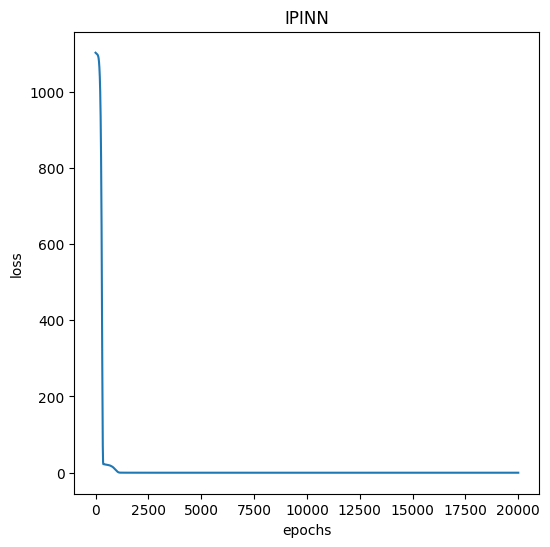

In [10]:
fig = plt.figure(figsize=(6,6))
plt.plot(range(n_epochs), loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('IPINN')

In [11]:
# Evaluate the model on the test set
IPINN.eval()
with torch.no_grad():
    test_outputs = IPINN(X_test_tensor)
    test_loss = lossFunction(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0059


In [12]:
# model = Net(
#     sizes=[2, 50, 50, 50, 1], activation='relu', dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0
#     )
# model.load_state_dict(final_model)
# model.eval()
# model.to(device)
# print(utils.test(device, model))